In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers

In [2]:
def get_y(x):
    return 10 + x*x


def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

In [3]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [5]:
class Generator(keras.Model):
    
    def __init__(self, random_noise_size = 2):
        super().__init__(name='generator')
        #layers
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.layer1=layers.Dense(16, activation='relu')
        self.layer2=layers.Dense(16,activation='relu')
        self.layer3=layers.Dense(2)
#         self.input_layer = keras.layers.Dense(units = random_noise_size)
#         self.dense_1 = keras.layers.Dense(units = 16)
#         self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
#         self.dense_2 = keras.layers.Dense(units = 16)
#         self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
#         self.dense_3 = keras.layers.Dense(units = 4)
#         self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
#         self.output_layer = keras.layers.Dense(units=2, activation = "tanh")
        
    def call(self, input_tensor):
        x=self.input_layer(input_tensor)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        ## Definition of Forward Pass
#         x = self.input_layer(input_tensor)
#         x = self.dense_1(x)
#         x = self.leaky_1(x)
#         x = self.dense_2(x)
#         x = self.leaky_2(x)
#         x = self.dense_3(x)
#         x = self.leaky_3(x)
        return  x
    
    def generate_noise(self,batch_size, random_noise_size):
        return np.random.uniform(-1,1, size = (batch_size, random_noise_size))

In [6]:
def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx)

In [7]:
generator = Generator()

In [8]:
fake = generator(np.random.uniform(-1,1, size =(1,2)))
print(fake)
# fake = tf.reshape(fake, shape = (28,28))
# plt.imshow(fake, cmap = "gray")

tf.Tensor([[-0.09020833  0.12754866]], shape=(1, 2), dtype=float32)


In [9]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        self.input_layer = keras.layers.Dense(units = 2)
        self.layer1=layers.Dense(16, activation='relu')
        self.layer2=layers.Dense(16,activation='relu')
        self.layer3=layers.Dense(1)
        #Layers
#         self.input_layer = keras.layers.Dense(units = 2)
#         self.dense_1 = keras.layers.Dense(units = 16)
#         self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
#         self.dense_2 = keras.layers.Dense(units = 16)
#         self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
#         self.dense_3 = keras.layers.Dense(units = 2)
#         self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        
        self.logits = keras.layers.Dense(units = 1)  # This neuron tells us if the input is fake or real
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
          ## Definition of Forward Pass
#         x = self.input_layer(input_tensor)
#         x = self.dense_1(x)
#         x = self.leaky_1(x)
#         x = self.leaky_2(x)
#         x = self.leaky_3(x)
#         x = self.leaky_3(x)
#         x = self.logits(x)
        return x

In [10]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    
    total_loss = tf.add(real_loss , fake_loss)
    
    return total_loss

In [11]:
discriminator = Discriminator()

In [12]:
generator_optimizer = keras.optimizers.RMSprop()
discriminator_optimizer = keras.optimizers.RMSprop()

In [13]:
@tf.function()
def training_step(generator: Discriminator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 32):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = generator.generate_noise(batch_size, 2)
            g_z = generator(noise)
            d_x_true = discriminator(images) # Trainable?
            d_x_fake = discriminator(g_z) # dx_of_gx

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 

In [14]:
# BATCH_SIZE = 256
# BUFFER_SIZE = 60000
# EPOCHES = 300
# OUTPUT_DIR = "img"
# mnist = keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# train_images = train_images.astype("float32")
# train_images = (train_images - 127.5) / 127.5
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0],784)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
dataset_size=100000
n=2
traindata=sample_data(dataset_size)
epochs = 5
batch_size = 100
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
    for j in range(batches_per_epoch):
        data_batch = traindata[batch_size*j:batch_size*(j+1)]
        training_step(generator, discriminator, data_batch ,batch_size = batch_size , k = 1)

In [16]:
# def training(dataset, epoches):
#     for epoch in range(epoches):
#         for batch in dataset: 
#             training_step(generator, discriminator, batch ,batch_size = BATCH_SIZE, k = 1)
            


In [17]:
# training(train_dataset, EPOCHES)

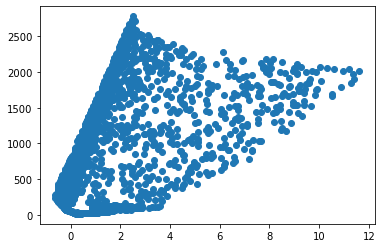

In [18]:
x=list()
for i in range(2000):
    x.append(generator(np.random.uniform(-1,1, size = (1, 2)))[0])
x=np.array(x)
plt.scatter(x[:,0],x[:,1])

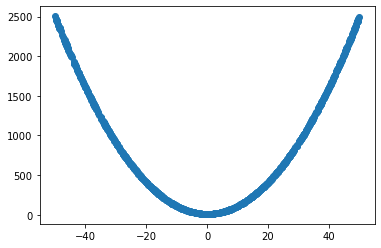

In [19]:
plt.scatter(traindata[0:1000,0],traindata[0:1000,1])